In [6]:
import os
from urllib.request import urlretrieve

# Download data
def download(url, dest_filename):
    # This function was copied from TensorFlow Lab
    dest_filepath = os.path.join(os.getcwd(), dest_filename)
    if not os.path.isfile(dest_filepath):
        print('Downloading ' + dest_filename + '...')
        file_name, headers = urlretrieve(url, filename=dest_filepath)
        print('Download finished - Saved to: ' + file_name)
download('https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip','data.zip')
print('All files downloaded.')

All files downloaded.


In [37]:
import zipfile

def unzip(file, path):
    fh = open(file, 'rb')
    z = zipfile.ZipFile(fh)
    for name in z.namelist():
        z.extract(name, path)
    fh.close()
    print('Done')

In [38]:
unzip('./data.zip', './')

Done


In [10]:
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D
#from keras.utils.visualize_util import plot
from keras.optimizers import Adam
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K


import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import json

In [11]:
drive_log_df = pd.read_csv('data/driving_log.csv')
drive_log_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


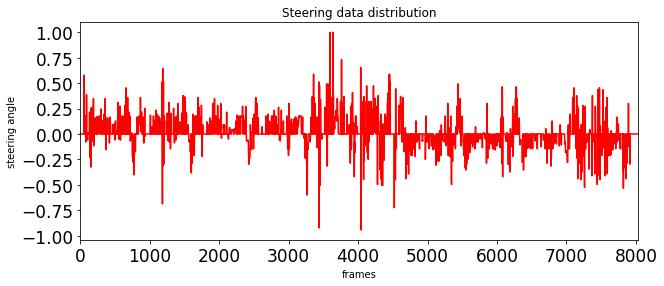

In [12]:
drive_log_df.steering.plot(title='Steering data distribution', fontsize=17, figsize=(10,4), color= 'r')
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.show()

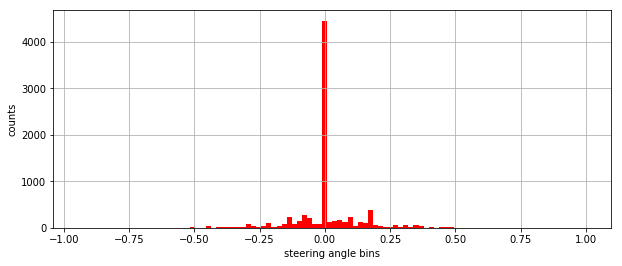

Dataset Size:  8036


In [13]:
plt.figure(figsize=(10,4))
drive_log_df.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Dataset Size: ", len(drive_log_df.steering))

In [14]:
zero_steering = drive_log_df[drive_log_df.steering == 0].sample(frac=0.9)
drive_log_df = drive_log_df.drop(zero_steering.index)

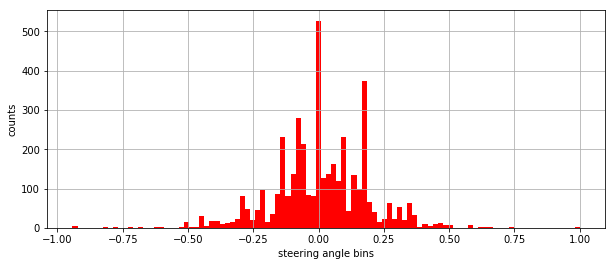

Current Dataset Size:  4111


In [15]:
plt.figure(figsize=(10,4))
drive_log_df.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(drive_log_df.steering))

In [16]:
def update_left_right_steering_correction(df):
    records = []
    for index, row in df.iterrows():
        left = row.left
        center = row.center
        right = row.right
        steering = row.steering
        
        records.append({
            'image': left,
            'steering': steering + 0.23
        })
        
        records.append({
            'image': right,
            'steering': steering - 0.23
        })
        
        records.append({
            'image': center,
            'steering': steering
        })
    
    return pd.DataFrame(data=records, columns=['image', 'steering'])

new_drive_log = update_left_right_steering_correction(drive_log_df)
new_drive_log.tail()

,image,steering
12328,IMG/right_2016_12_01_13_46_37_379.jpg,-0.23
12329,IMG/center_2016_12_01_13_46_37_379.jpg,0.00
12330,IMG/left_2016_12_01_13_46_38_922.jpg,0.23
12331,IMG/right_2016_12_01_13_46_38_922.jpg,-0.23
12332,IMG/center_2016_12_01_13_46_38_922.jpg,0.00


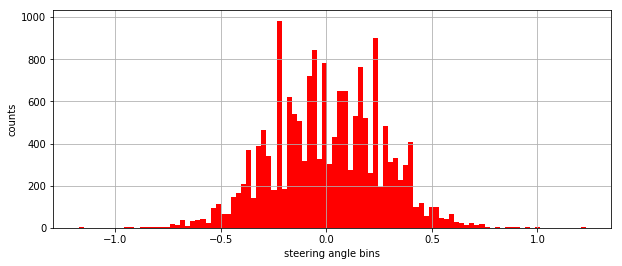

Current Dataset Size:  17092


In [17]:
def flip_images_augmentation(df):
    new_df = df[df.steering != 0].sample(frac=0.4)
    df.loc[:,'is_flipped'] = False
    new_df.loc[:,'is_flipped'] = True
    left_rows = (new_df.steering < 0)
    right_rows = (new_df.steering > 0)
    new_df.loc[left_rows,'steering'] = new_df[left_rows].steering.abs()
    new_df.loc[right_rows, 'steering'] = new_df[right_rows].steering * -1
    return pd.concat([df, new_df])

augmented = flip_images_augmentation(new_drive_log)
plt.figure(figsize=(10,4))
augmented.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(augmented.steering))

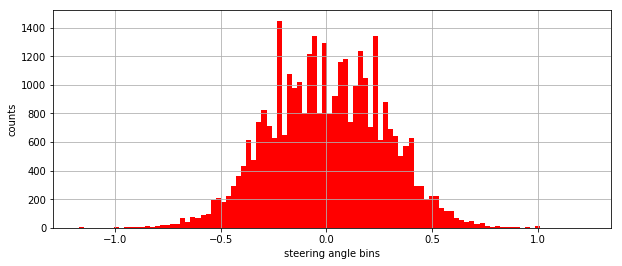

Current Dataset Size:  33748


In [18]:
def shift_img_augmentation(df):
    df.loc[:,'random_shift'] = 0
    new_df = df[df.steering != 0].copy()
    df.loc[:,'is_shift'] = False
    new_df.loc[:,'is_shift'] = True
    
    
    max_shift = 30
    max_ang = 0.17
    
    def row_shift_update(row):
        random_shift = np.random.randint(-max_shift, max_shift + 1)
        row.random_shift = random_shift
        updated_steer = row.steering + (random_shift / max_shift) * max_ang
        if abs(updated_steer) > 1:
            updated_steer = -1 if (updated_steer < 0) else 1

        row.steering = updated_steer
        return row

    new_df = new_df.apply(row_shift_update, axis=1)
    return pd.concat([df, new_df])

shifted = shift_img_augmentation(augmented)
plt.figure(figsize=(10,4))
shifted.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(shifted.steering))

shifted.tail(1)
plt.show()

In [19]:
def process_driver_log(driver_log):
    update_log = update_left_right_steering_correction(driver_log)
    update_log = flip_images_augmentation(update_log)
    update_log = shift_img_augmentation(update_log)
    #update_log = change_brightness_augmentation(update_log)
    
    #reset index since we it's no longer good.
    update_log = update_log.reset_index(drop=True)
    
    #drop outbound steering examples to be between [-1,1] !
    outbound_steering = update_log[abs(update_log.steering) > 1]
    update_log = update_log.drop(outbound_steering.index)

    return update_log

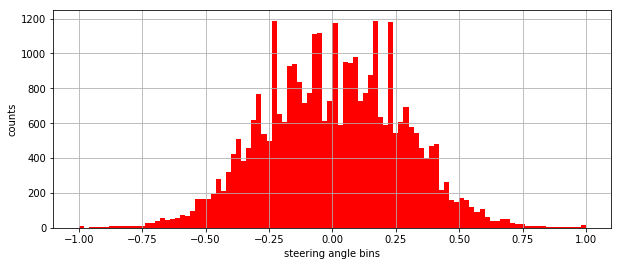

Current Dataset Size:  33735


In [20]:
processed_log = process_driver_log(drive_log_df)

plt.figure(figsize=(10,4))
processed_log.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(processed_log.steering))


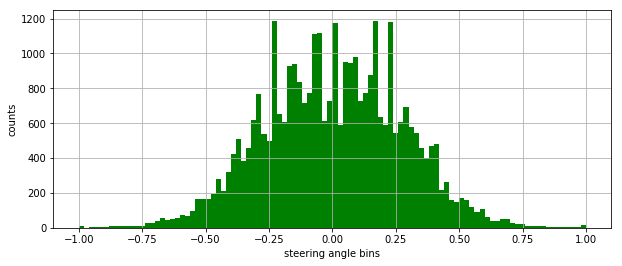

Current Dataset Size:  33735


In [21]:
plt.figure(figsize=(10,4))
processed_log.steering.hist(bins=100, color='g')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(processed_log.steering))


In [22]:
hist, counts = np.histogram(processed_log.steering, bins=100)
upper_limit = 400
over = [(i, v) for i, v in enumerate(hist) if v > upper_limit ]
over_ranges = [(counts[i],counts[i+1]) for i,_ in over]

#loop through ranges and create a mask for each bin 
masks = ["processed_log[(processed_log.steering >= {0}) & (processed_log.steering < {1})]".format(l,r) for l,r in over_ranges]

for mask in masks:
    selected = eval(mask)
    selected_length = len(selected)
    frac_to_drop = (selected_length-upper_limit)/selected_length
    samples_to_drop = selected.sample(frac=frac_to_drop)
    processed_log = processed_log.drop(samples_to_drop.index)

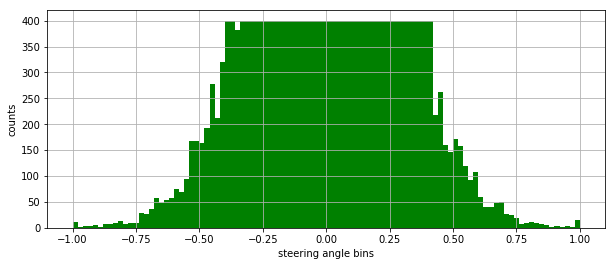

Current Dataset Size:  20346


In [23]:
plt.figure(figsize=(10,4))
processed_log.steering.hist(bins=100, color='g')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(processed_log.steering))


In [24]:
processed_log.to_csv('preprocessed_driver_log.csv')

In [42]:
import pandas as pd
import cv2
import random
import numpy as np

def crop_top_and_bottom(image):
    resized = cv2.resize(image[70:140], (64,64),  cv2.INTER_AREA)
    return cv2.cvtColor(resized, cv2.COLOR_RGB2HSV)[:,:,1]


def shift_img(image, random_shift):
    rows, cols = image.shape
    mat = np.float32([[1, 0, random_shift], [0, 1, 0]])
    return cv2.warpAffine(image, mat, (cols, rows))

def load_image(row):
    fileName = "./data/{0}".format(row.image.strip())
    #print(fileName)
    image = cv2.imread(fileName)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_top_and_bottom(image)

    if(row.is_flipped):
        image = cv2.flip(image,1)
    if(row.is_shift):
        image = shift_img(image, row.random_shift)
    return image

def get_processed_dataframes():

    return pd.read_csv('preprocessed_driver_log.csv')

In [40]:
from keras.models import Model
from keras.layers import Dense, Dropout, ELU, Lambda, merge, MaxPooling2D, Input, Activation, GlobalAveragePooling2D
from keras.layers.convolutional import Convolution2D
from keras.callbacks import Callback
from keras.optimizers import Adam
import numpy as np
from sklearn.utils import shuffle
import json
import preprocess_util as preprocess
import keras.backend as K
import gc

#hyperparameters
INPUT_SHAPE = (64, 64, 1)
LEARNING_RATE = 1e-1
BATCH_SIZE = 128
EPOCHS = 50

class CustomEarlyStop(Callback):

    def __init__(self, monitor='val_loss'):
        super(CustomEarlyStop, self).__init__()
        self.monitor = monitor


    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get(self.monitor)
        if val_loss <= 0.039:
            print("\nEarly Stop on Epoch {0} with Val_loss {1}\n".format(epoch,val_loss))
            self.model.stop_training = True

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'
    c_axis = 3
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    elu = "elu_"

    x = Convolution2D(squeeze, 1, 1, border_mode='valid', name=s_id + sq1x1)(x)
    x = Activation('elu', name=s_id + elu + sq1x1)(x)

    left = Convolution2D(expand, 1, 1, border_mode='valid', name=s_id + exp1x1)(x)
    left = Activation('elu', name=s_id + elu + exp1x1)(left)

    right = Convolution2D(expand, 3, 3, border_mode='same', name=s_id + exp3x3)(x)
    right = Activation('elu', name=s_id + elu + exp3x3)(right)

    x = merge([left, right], mode='concat', concat_axis=c_axis, name=s_id + 'concat')
    return x

def squeeze_model_52():
    input_shape=(64, 64, 1)
    input_img = Input(shape=input_shape)
    x = Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape)(input_img)

    x = Convolution2D(2, 3, 3, subsample=(2, 2), border_mode='valid', name='conv1')(x)
    x = Activation('elu', name='elu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=1, expand=2)
    x = Dropout(0.2, name='drop3')(x)


    x = GlobalAveragePooling2D()(x)
    out = Dense(1, name='loss')(x)
    model = Model(input=input_img, output=[out])

    model.compile(optimizer=Adam(lr=LEARNING_RATE), loss='mse')
    return model


def load_all_images():
    driverlog_df = get_processed_dataframes()
    print("driverlog_df loaded: ", len(driverlog_df))
    print("Loading images from log file now....")
    features = [load_image(row) for _, row in driverlog_df.iterrows()]
    labels   = driverlog_df.steering

    return np.array(features).reshape(len(features), 64, 64, 1), labels

def train():
    model = squeeze_model_52()
    
    model.summary()

    features, labels = load_all_images()
    #this is the early termination callback. Stops trainig when val_loss <=.039
    early_stop = CustomEarlyStop(monitor='val_loss')
    model.fit(x=features,
              y=labels,
              verbose=1,
              batch_size=BATCH_SIZE,
              nb_epoch=EPOCHS,
              validation_split=0.3,
              callbacks=[early_stop])

    model.save("model.h5")
    print("Training complete!")

    #Clean up after ourselves!!
    K.clear_session()
    gc.collect()

In [41]:
train()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
lambda_7 (Lambda)                (None, 64, 64, 1)     0           input_7[0][0]                    
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 31, 2)     20          lambda_7[0][0]                   
____________________________________________________________________________________________________
elu_conv1 (Activation)           (None, 31, 31, 2)     0           conv1[0][0]                      
___________________________________________________________________________________________